# Импорт библиотек

In [1]:
import time
import calendar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

# Импорт моделей

In [2]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor


In [3]:
# путь к папке с данными
DATA_DIR = 'data'
PROJECT_DIR = os.getcwd()

# Список файлов
files = ['air_reserve.csv', 'air_store_info.csv', 'air_visit_data.csv', 
         'date_info.csv', 'hpg_reserve.csv', 'hpg_store_info.csv', 
         'store_id_relation.csv']

# Чтение всех CSV-файлов
for file in files:
    filepath = os.path.join(PROJECT_DIR, DATA_DIR, file)
    try:
        pd.read_csv(filepath)
        print(f"Файл '{file}' успешно загружен.")
    except FileNotFoundError:
        print(f"Ошибка: Файл '{file}' не найден.")

Файл 'air_reserve.csv' успешно загружен.
Файл 'air_store_info.csv' успешно загружен.
Файл 'air_visit_data.csv' успешно загружен.
Файл 'date_info.csv' успешно загружен.
Файл 'hpg_reserve.csv' успешно загружен.
Файл 'hpg_store_info.csv' успешно загружен.
Файл 'store_id_relation.csv' успешно загружен.


# Анализ начальных данных

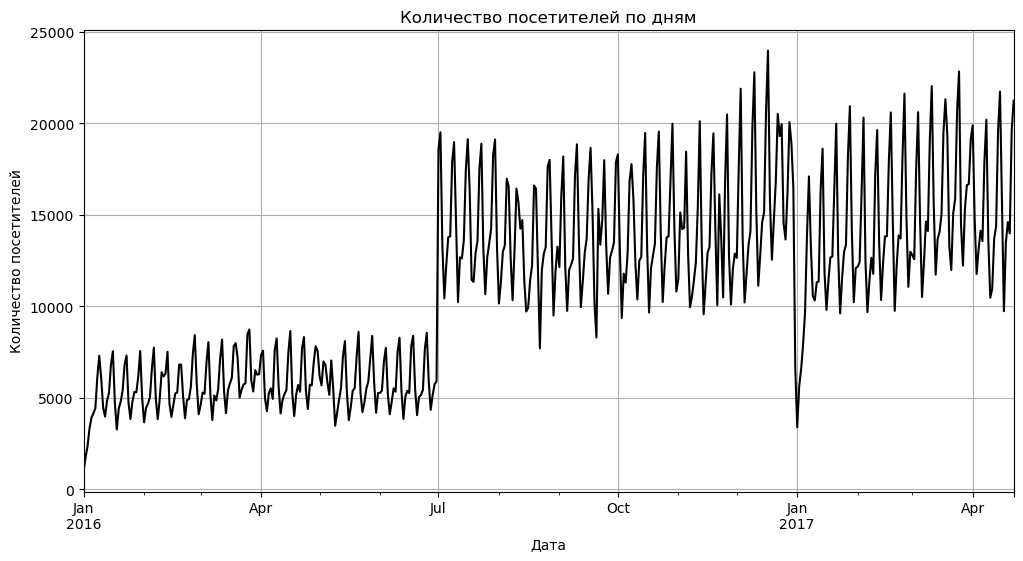

In [4]:
air_visit_data = pd.read_csv("data/air_visit_data.csv",encoding='unicode_escape')
air_visit_data['visit_date'] = pd.to_datetime(air_visit_data['visit_date'])
daily_visitors = air_visit_data.groupby('visit_date')['visitors'].sum()

plt.figure(figsize=(12, 6))
daily_visitors.plot(color='black')
plt.title('Количество посетителей по дням')
plt.xlabel('Дата')
plt.ylabel('Количество посетителей')
plt.grid()
plt.show()

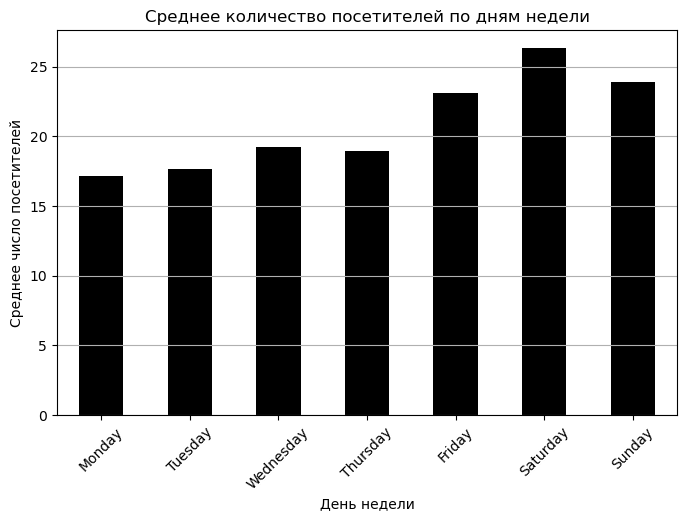

In [5]:
air_visit_data['day_of_week'] = air_visit_data['visit_date'].dt.dayofweek
visitors_by_weekday = air_visit_data.groupby('day_of_week')['visitors'].mean()

plt.figure(figsize=(8, 5))
visitors_by_weekday.plot(kind='bar', color='black')
plt.title('Среднее количество посетителей по дням недели')
plt.xlabel('День недели')
plt.ylabel('Среднее число посетителей')
plt.xticks(ticks=range(7), labels=[calendar.day_name[i] for i in range(7)], rotation=45)
plt.grid(axis='y')
plt.show()

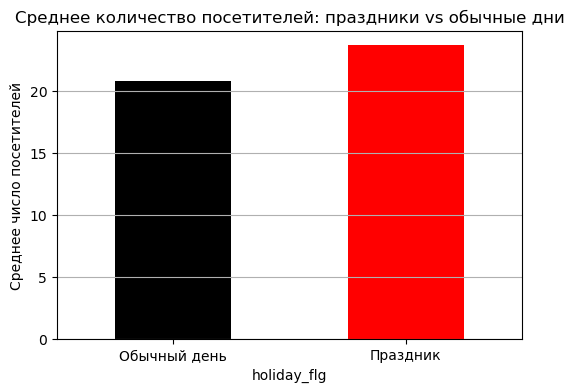

In [6]:
air_visit_data['visit_date'] = pd.to_datetime(air_visit_data['visit_date'])
date_info = pd.read_csv("data/date_info.csv")
date_info['calendar_date'] = pd.to_datetime(date_info['calendar_date'])
merged_data = air_visit_data.merge(date_info, left_on='visit_date', right_on='calendar_date')
holiday_visitors = merged_data.groupby('holiday_flg')['visitors'].mean()

plt.figure(figsize=(6, 4))
holiday_visitors.plot(kind='bar', color=['black', 'red'])
plt.title('Среднее количество посетителей: праздники vs обычные дни')
plt.ylabel('Среднее число посетителей')
plt.xticks(ticks=[0, 1], labels=['Обычный день', 'Праздник'], rotation=0)
plt.grid(axis='y')
plt.show()

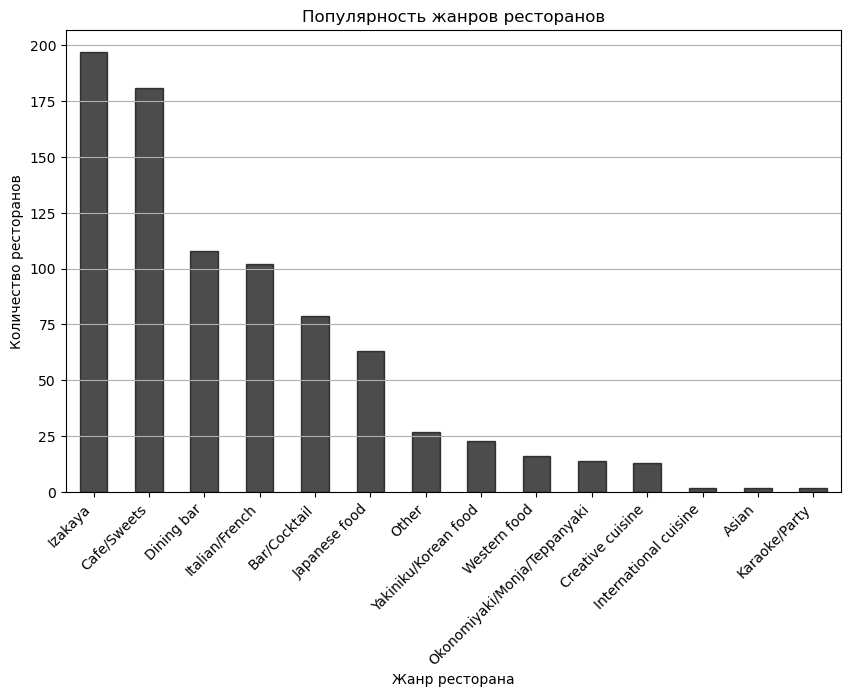

In [7]:
air_store_info = pd.read_csv("data/air_store_info.csv")
genre_counts = air_store_info['air_genre_name'].value_counts()

plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', color='black', edgecolor='black', alpha=0.7)
plt.title('Популярность жанров ресторанов')
plt.xlabel('Жанр ресторана')
plt.ylabel('Количество ресторанов')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()

### Читаем данные

In [8]:
air_reserve = pd.read_csv("data/air_reserve.csv")
hpg_reserve = pd.read_csv("data/hpg_reserve.csv")
air_store_info = pd.read_csv("data/air_store_info.csv")
hpg_store_info = pd.read_csv("data/hpg_store_info.csv")
store_id_relation = pd.read_csv("data/store_id_relation.csv")
air_visit_data = pd.read_csv("data/air_visit_data.csv")
date_info = pd.read_csv("data/date_info.csv")
sample_submission = pd.read_csv('data/sample_submission.csv')

# Подготовка данных

### Мапим в тип datetime

In [9]:
air_visit_data['visit_date'] = pd.to_datetime(air_visit_data['visit_date'])
date_info['calendar_date'] = pd.to_datetime(date_info['calendar_date'])

### Мерджим таблицы, дропаем ненужные колонки
- мерджим `air_visit_data` и `date_info` по признаку даты
- дропаем `calendar_date` и добавляем новый столбец с месяцем

In [10]:
air_visit_data = air_visit_data.merge(
    date_info, left_on='visit_date', right_on='calendar_date', how='left'
)
air_visit_data = air_visit_data.drop(columns=['calendar_date'])
air_visit_data['month'] = air_visit_data['visit_date'].dt.month

### Мерджим таблицы, дропаем ненужные колонки
- мерджим `air_visit_data` и `air_store_info` по `id` магазина
- дропаем время резервирования и приводим к типу данных время посещения

In [11]:
air_visit_data = air_visit_data.merge(
    air_store_info[['air_store_id', 'air_genre_name', 'air_area_name', 'latitude', 'longitude']], on='air_store_id', how='left'
)
air_reserve = air_reserve.drop(columns=['reserve_datetime'])
air_reserve['visit_datetime'] = pd.to_datetime(air_reserve['visit_datetime']).dt.date

### Группируем
- группируем в таблице `air_reserve` `id` ресторана и дате посещения
- суммируем по количеству посетителей

In [12]:
air_reserve = air_reserve.groupby(['air_store_id', 'visit_datetime'], as_index=False, sort=False)['reserve_visitors'].sum()
air_reserve['visit_datetime'] = pd.to_datetime(air_reserve['visit_datetime'])
air_visit_data = air_visit_data.merge(
    air_reserve[['air_store_id', 'visit_datetime', 'reserve_visitors']], left_on=['air_store_id', 'visit_date'], right_on=['air_store_id', 'visit_datetime'], how='left'
)
air_visit_data = air_visit_data.drop(columns=['visit_datetime'])

### Заполняем нулями и unknown пустые ячейки

In [13]:
air_visit_data['reserve_visitors'] = air_visit_data['reserve_visitors'].fillna(0)
air_visit_data = air_visit_data.merge(
    store_id_relation[['air_store_id', 'hpg_store_id']], on='air_store_id', how='left'
)
air_visit_data['hpg_store_id'] = air_visit_data['hpg_store_id'].fillna('unknown')

### Итоговая таблица

In [14]:
air_visit_data

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,month,air_genre_name,air_area_name,latitude,longitude,reserve_visitors,hpg_store_id
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0,1,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,unknown
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,0,1,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,unknown
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,0,1,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,unknown
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,0,1,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,unknown
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,0,1,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6,Tuesday,0,4,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,0.0,unknown
252104,air_24e8414b9b07decb,2017-04-19,6,Wednesday,0,4,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,0.0,unknown
252105,air_24e8414b9b07decb,2017-04-20,7,Thursday,0,4,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,0.0,unknown
252106,air_24e8414b9b07decb,2017-04-21,8,Friday,0,4,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,0.0,unknown


### Предобработка sample_submission
- Извлекаем `air_store_id` и `visit_date` из столбца `id`.
- Преобразуем `visit_date` в формат datetime.
- Удаляем столбец `id`.

In [15]:
sample_submission['air_store_id'] = sample_submission['id'].apply(lambda x: '_'.join(x.split('_')[:-1]))
sample_submission['visit_date'] = sample_submission['id'].apply(lambda x: x.split('_')[-1])
sample_submission['visit_date'] = pd.to_datetime(sample_submission['visit_date'])
sample_submission = sample_submission.drop(columns=['id'])

### Обработка sample_submission
1. Переносим столбец `visitors` (создаем новый).
2. Объединяем с `date_info` по дате (`visit_date` и `calendar_date`), затем удаляем `calendar_date`.
3. Добавляем столбец `month` (месяц из `visit_date`).
4. Объединяем с информацией о ресторанах (`air_store_info`) по `air_store_id`.
5. Объединяем с данными о бронированиях (`air_reserve`) по `air_store_id` и `visit_date`, заполняя пропуски в `reserve_visitors` нулями.
6. Объединяем с таблицей связей ресторанов (`store_id_relation`), заменяя пропуски в `hpg_store_id` на `'unknown'`.

In [16]:
sample_submission['visitors'] = sample_submission.pop('visitors')
sample_submission = sample_submission.merge(
    date_info, left_on='visit_date', right_on='calendar_date', how='left'
)
sample_submission = sample_submission.drop(columns=['calendar_date'])
sample_submission['month'] = sample_submission['visit_date'].dt.month

sample_submission = sample_submission.merge(
    air_store_info[['air_store_id', 'air_genre_name', 'air_area_name', 'latitude', 'longitude']], on='air_store_id', how='left'
)

sample_submission = sample_submission.merge(
    air_reserve[['air_store_id', 'visit_datetime', 'reserve_visitors']],
    left_on=['air_store_id', 'visit_date'],
    right_on=['air_store_id', 'visit_datetime'],
    how='left'
)
sample_submission = sample_submission.drop(columns=['visit_datetime'])
sample_submission['reserve_visitors'] = sample_submission['reserve_visitors'].fillna(0)

sample_submission = sample_submission.merge(
    store_id_relation[['air_store_id', 'hpg_store_id']], on='air_store_id', how='left'
)

sample_submission['hpg_store_id'] = sample_submission['hpg_store_id'].fillna('unknown')

sample_submission


,air_store_id,visit_date,visitors,day_of_week,holiday_flg,month,air_genre_name,air_area_name,latitude,longitude,reserve_visitors,hpg_store_id
0,air_00a91d42b08b08d9,2017-04-23,0,Sunday,0,4,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0.0,hpg_fbe603376b5980fc
1,air_00a91d42b08b08d9,2017-04-24,0,Monday,0,4,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0.0,hpg_fbe603376b5980fc
2,air_00a91d42b08b08d9,2017-04-25,0,Tuesday,0,4,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0.0,hpg_fbe603376b5980fc
3,air_00a91d42b08b08d9,2017-04-26,0,Wednesday,0,4,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0.0,hpg_fbe603376b5980fc
4,air_00a91d42b08b08d9,2017-04-27,0,Thursday,0,4,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0.0,hpg_fbe603376b5980fc
...,...,...,...,...,...,...,...,...,...,...,...,...
32014,air_fff68b929994bfbd,2017-05-27,0,Saturday,0,5,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,0.0,unknown
32015,air_fff68b929994bfbd,2017-05-28,0,Sunday,0,5,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,0.0,unknown
32016,air_fff68b929994bfbd,2017-05-29,0,Monday,0,5,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,0.0,unknown
32017,air_fff68b929994bfbd,2017-05-30,0,Tuesday,0,5,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,0.0,unknown


### Очистка данных о посещениях ресторанов (air_visit_data)
1. **Очистка данных на уровне ресторанов:**
   - Для каждого ресторана (`air_store_id`) вычисляются квартильные значения (`quantile_min` и `quantile_max`) и межквартильный размах (`diff`).
   - Определяются границы выбросов: 
     - Нижняя граница: `max(0, quantile_min - 1.5 * diff)`.
     - Верхняя граница: `quantile_max + 1.5 * diff`.
   - Данные о посещаемости вне этих границ удаляются.

2. **Очистка глобальных выбросов:**
   - По очищенным данным рассчитываются глобальные `quantile_min_global`, `quantile_max_global` и `diff_global`.
   - Вычисляются глобальные границы выбросов:
     - Нижняя граница: `max(0, quantile_min_global - 1.5 * diff_global)`.
     - Верхняя граница: `quantile_max_global + 1.5 * diff_global`.
   - Данные, выходящие за эти границы, удаляются из финального набора.

3. **Результат:**
   - `cleaned_air_visit_data`: очищенные данные без локальных и глобальных выбросов.
   - `anomalies`: сохранены глобальные выбросы для возможного анализа.


In [17]:
cleaned_air_visit_data = pd.DataFrame()
for store_id, group in air_visit_data.groupby('air_store_id', as_index=False, sort=False):
    quantile_min = group['visitors'].quantile(0.25)
    quantile_max = group['visitors'].quantile(0.75)
    diff = quantile_max - quantile_min
    lower_bound = max(0, quantile_min - 1.5 * diff)
    upper_bound = quantile_max + 1.5 * diff
    cleaned_group = group[(group['visitors'] >= lower_bound) & (group['visitors'] <= upper_bound)]
    cleaned_air_visit_data = pd.concat([cleaned_air_visit_data, cleaned_group])

quantile_min_global = cleaned_air_visit_data['visitors'].quantile(0.25)
quantile_max_global = cleaned_air_visit_data['visitors'].quantile(0.75)
diff_global = quantile_max_global - quantile_min_global

lower_bound_global = max(0, quantile_min_global - 1.5 * diff_global)
upper_bound_global = quantile_max_global + 1.5 * diff_global
anomalies = cleaned_air_visit_data[
    (cleaned_air_visit_data['visitors'] < lower_bound_global) |
    (cleaned_air_visit_data['visitors'] > upper_bound_global)
    ]
cleaned_air_visit_data = cleaned_air_visit_data[
    (cleaned_air_visit_data['visitors'] >= lower_bound_global) &
    (cleaned_air_visit_data['visitors'] <= upper_bound_global)
    ]

### Результаты обработки выбросов

In [18]:
print(f'Количество глобальных аномальных точек: {len(anomalies)}')
print(f'Новый размер массива данных: {len(cleaned_air_visit_data)}')
print(f'Квартиль 25% в целом: {quantile_min_global}')
print(f'Квартиль 75% в целом: {quantile_max_global}')
print(f'Межквартиль в целом: {diff_global}')
print(f'Границы отклонения в целом: [{lower_bound_global}, {upper_bound_global}]')

Количество глобальных аномальных точек: 6925
Новый размер массива данных: 240023
Квартиль 25% в целом: 9.0
Квартиль 75% в целом: 28.0
Межквартиль в целом: 19.0
Границы отклонения в целом: [0, 56.5]


In [19]:
cleaned_air_visit_data.reset_index(drop=True, inplace=True)
cleaned_air_visit_data

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,month,air_genre_name,air_area_name,latitude,longitude,reserve_visitors,hpg_store_id
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0,1,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,unknown
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,0,1,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,unknown
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,0,1,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,unknown
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,0,1,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,unknown
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,0,1,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...
240018,air_24e8414b9b07decb,2017-04-18,6,Tuesday,0,4,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,0.0,unknown
240019,air_24e8414b9b07decb,2017-04-19,6,Wednesday,0,4,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,0.0,unknown
240020,air_24e8414b9b07decb,2017-04-20,7,Thursday,0,4,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,0.0,unknown
240021,air_24e8414b9b07decb,2017-04-21,8,Friday,0,4,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,0.0,unknown


In [20]:
cleaned_air_visit_data_encoded = cleaned_air_visit_data.copy().reset_index(drop=True)
cleaned_air_visit_data_merge = cleaned_air_visit_data.copy().reset_index(drop=True)

### Кодировка категориальных признаков
1. Выбраны признаки: `day_of_week`, `holiday_flg`, `month`, `air_genre_name`, `air_area_name`, `hpg_store_id`.
2. Применён `OneHotEncoder` для кодирования категорий (игнор неизвестных, drop первой категории).
3. Закодированные признаки объединены с таблицей.
4. Удалены исходные и ненужные столбцы: `air_store_id`, `visit_date`, `visitors`, `day_of_week`, `holiday_flg`, `month`, `air_genre_name`, `air_area_name`, `hpg_store_id`.

In [21]:

selected_features = cleaned_air_visit_data[['day_of_week', 'holiday_flg', 'month', 'air_genre_name', 'air_area_name', 'hpg_store_id']]
encoder = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(selected_features)
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(selected_features.columns))
cleaned_air_visit_data_encoded = pd.concat([cleaned_air_visit_data_merge, encoded_df], axis=1)
cleaned_air_visit_data_encoded = cleaned_air_visit_data_encoded.drop(columns=['air_store_id', 'visit_date',
                                                                              'visitors', 'day_of_week',
                                                                              'holiday_flg', 'month',
                                                                              'air_genre_name', 'air_area_name',
                                                                              'hpg_store_id'])



### Кодировка категориальных признаков для тестового набора
1. Создана копия `sample_submission` в `sample_submission_encoded`.
2. Выбраны признаки для кодировки: `day_of_week`, `holiday_flg`, `month`, `air_genre_name`, `air_area_name`, `hpg_store_id`.
3. Применён `OneHotEncoder` для кодирования выбранных признаков.
4. Создан DataFrame `encoded_df_test` с закодированными признаками.
5. Объединён `sample_submission` с закодированными признаками.
6. Удалены ненужные столбцы: 
   - `air_store_id`, `visit_date`, `visitors`, 
   - `day_of_week`, `holiday_flg`, `month`, 
   - `air_genre_name`, `air_area_name`, `hpg_store_id`.

In [22]:
sample_submission_encoded = sample_submission.copy()
selected_features_test = sample_submission_encoded[['day_of_week', 'holiday_flg', 'month', 'air_genre_name', 'air_area_name', 'hpg_store_id']]

encoded_features_test = encoder.fit_transform(selected_features_test)
encoded_df_test = pd.DataFrame(encoded_features_test, columns=encoder.get_feature_names_out(selected_features_test.columns))

sample_submission_encoded = pd.concat([sample_submission, encoded_df_test], axis=1)
sample_submission_encoded = sample_submission_encoded.drop(columns=['air_store_id', 'visit_date',
                                                                    'visitors', 'day_of_week',
                                                                    'holiday_flg', 'month',
                                                                    'air_genre_name', 'air_area_name',
                                                                    'hpg_store_id'])



### Обработка отсутствующих столбцов в тестовом наборе
1. Проверка, есть ли в `sample_submission_encoded` столбцы `month_1`–`month_12` (кодированные месяцы).
2. Для отсутствующих столбцов создаются новые с значением `0.0`.
3. Приведение структуры `sample_submission_encoded` к структуре `cleaned_air_visit_data_encoded` (одинаковые столбцы).
4. Вывод информации о структурах:
   - `cleaned_air_visit_data_encoded.info()` — проверка столбцов и их типов в обучающих данных.
   - `sample_submission_encoded.info()` — проверка столбцов и их типов в тестовых данных.
5. Итоговый DataFrame `sample_submission_encoded` готов для использования.


In [23]:
missing_month_columns = [f'month_{i}' for i in range(1, 13) if f'month_{i}' not in sample_submission_encoded.columns]
for col in missing_month_columns:
    sample_submission_encoded[col] = 0.0
sample_submission_encoded = sample_submission_encoded[cleaned_air_visit_data_encoded.columns]

cleaned_air_visit_data_encoded.info()
sample_submission_encoded.info()
sample_submission_encoded


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240023 entries, 0 to 240022
Columns: 285 entries, latitude to hpg_store_id_unknown
dtypes: float64(285)
memory usage: 521.9 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32019 entries, 0 to 32018
Columns: 285 entries, latitude to hpg_store_id_unknown
dtypes: float64(285)
memory usage: 69.6 MB


,latitude,longitude,reserve_visitors,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,holiday_flg_1,...,hpg_store_id_hpg_ee8cad9cd96718da,hpg_store_id_hpg_ef517ab154f66a8e,hpg_store_id_hpg_f07ec7b288165b27,hpg_store_id_hpg_f39996d4f0ebcb64,hpg_store_id_hpg_f76ad2d2d0134bdd,hpg_store_id_hpg_f83413cde79ac5e7,hpg_store_id_hpg_fa4eeada9ad7b59f,hpg_store_id_hpg_fbe603376b5980fc,hpg_store_id_hpg_fc892fe8d342a787,hpg_store_id_unknown
0,35.694003,139.753595,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,35.694003,139.753595,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,35.694003,139.753595,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,35.694003,139.753595,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,35.694003,139.753595,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32014,35.708146,139.666288,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
32015,35.708146,139.666288,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
32016,35.708146,139.666288,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
32017,35.708146,139.666288,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Графики по итоговому датафрейму

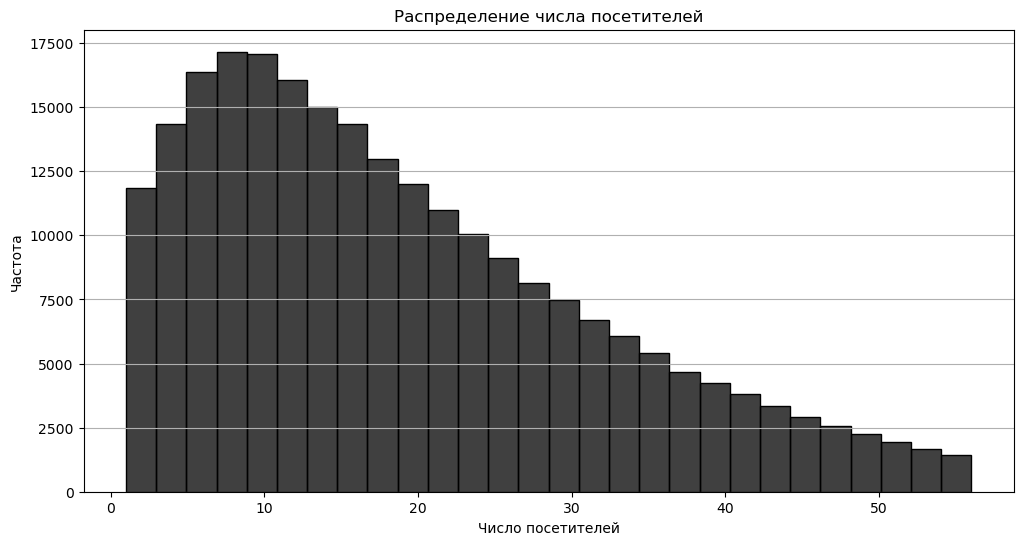

In [24]:
plt.figure(figsize=(12, 6))
sns.histplot(cleaned_air_visit_data['visitors'], bins=28, color='black')
plt.title('Распределение числа посетителей')
plt.xlabel('Число посетителей')
plt.ylabel('Частота')
plt.grid(axis='y')
plt.show()

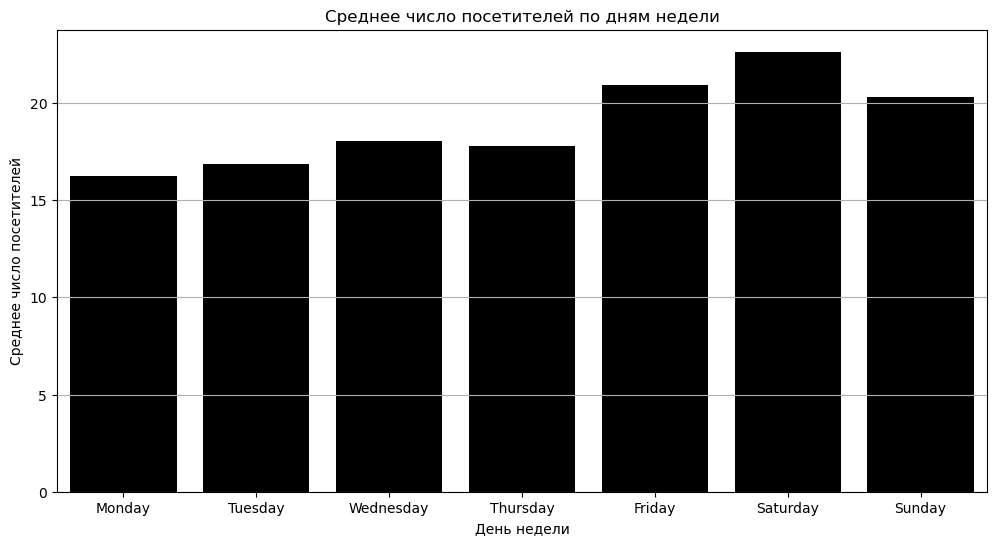

In [25]:
visitors_by_day = cleaned_air_visit_data.groupby('day_of_week', sort=False)['visitors'].mean()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(12, 6))
sns.barplot(x='day_of_week', y='visitors', data=visitors_by_day.reset_index(), order=days, color='black')
plt.title('Среднее число посетителей по дням недели')
plt.xlabel('День недели')
plt.ylabel('Среднее число посетителей')
plt.grid(axis='y')
plt.show()

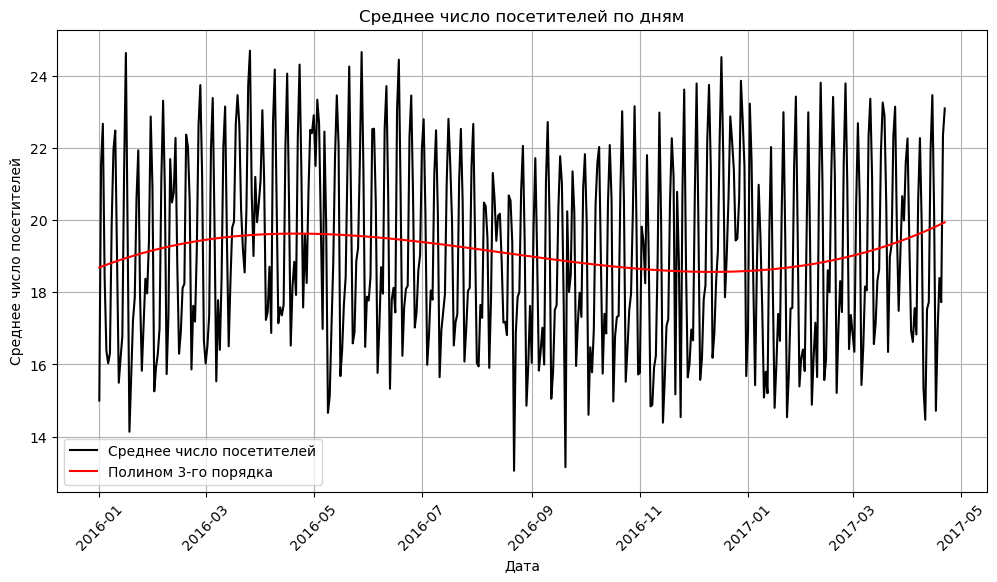

In [26]:
avg_visitors = cleaned_air_visit_data.groupby('visit_date')['visitors'].mean().reset_index()
avg_X = (avg_visitors['visit_date'] - avg_visitors['visit_date'].min()).dt.days.values.reshape(-1, 1)
avg_y = avg_visitors['visitors']
polynom = PolynomialFeatures(degree=3)
polynom_X = polynom.fit_transform(avg_X)
model = LinearRegression()
model.fit(polynom_X, avg_y)
polynom_pred_y = model.predict(polynom_X)
plt.figure(figsize=(12, 6))
plt.plot(avg_visitors['visit_date'], avg_visitors['visitors'], color='black', label='Среднее число посетителей')
plt.plot(avg_visitors['visit_date'], polynom_pred_y, color='red', label='Полином 3-го порядка')
plt.title('Среднее число посетителей по дням')
plt.xlabel('Дата')
plt.ylabel('Среднее число посетителей')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

### Разделение данных
- Признаки: `X_train = cleaned_air_visit_data_encoded`.
- Цель: `y_train = cleaned_air_visit_data['visitors']`.
- 70% в `X_train_split`, `y_train_split`, 30% в `X_val_split`, `y_val_split`.


In [27]:
X_train = cleaned_air_visit_data_encoded
y_train = cleaned_air_visit_data['visitors']
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42
)

# Выбор моделей

### Создание моделей с гиперпараметрами
- `Linear Regression`
- `XGBoost`
- `RandomForestRegressor`
- `GradientBoostingRegressor`
- `ExtraTreesRegressor`
- `AdaBoostRegressor`
- `Ridge`
- `Lasso`
- `ElasticNet`
- `DecisionTreeRegressor`
- `KNeighborsRegressor`

In [28]:
models = {
    "Linear Regression": LinearRegression(),
    "XGBoost": XGBRegressor(),
    "RandomForestRegressor": RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'ExtraTreesRegressor': ExtraTreesRegressor(),
    'AdaBoostRegressor': AdaBoostRegressor(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor()
}

In [29]:
hyper_parameters = {
    "Linear Regression": {},
    "XGBoost": {
        'n_estimators': [200],
        'learning_rate': [0.6],
        'max_depth': [8],
        'objective': ['reg:squarederror'],
        'random_state': [42]
    },
    "RandomForestRegressor": {
        'n_estimators': [100],
        'random_state': [42]
    },
    'GradientBoostingRegressor':{
        'n_estimators': [100],
        'random_state': [42]
    },
    'ExtraTreesRegressor':{
        'n_estimators': [100], 
        'n_jobs': [-1],
        'random_state': [42]
    },
    'AdaBoostRegressor':{
        'n_estimators': [100],
        'random_state': [42]
    },
    'Ridge':{
        'alpha': [1.0]
    },
    'Lasso': {
        'alpha': [1.0]
    },
    'ElasticNet': {
        'alpha': [1.0], 
        'l1_ratio': [0.5]
    },
    'DecisionTreeRegressor':{
        'random_state': [42]
    },
    'KNeighborsRegressor':{
        'n_neighbors': [5]
    }
}

# Обучение моделей

### Обучение моделей и оценка ошибок
1. **Процесс обучения:**
   - Для каждой модели из `models` выполняется:
     - Если гиперпараметры присутствуют:
       - Используется `GridSearchCV` для поиска лучших гиперпараметров.
       - Обучается модель с лучшими параметрами, делаются предсказания.
     - Если гиперпараметры отсутствуют:
       - Модель обучается с параметрами по умолчанию, делаются предсказания.

2. **Оценка модели:**
   - Для каждой модели вычисляются:
     - **MAE (средняя абсолютная ошибка)**.
     - **MAPE (средняя абсолютная ошибка в процентах)**.

3. **Результаты:**
   - `model_scores`: Словарь с MAE для каждой модели.
   - `mape_scores`: Словарь с MAPE для каждой модели.


In [30]:
mae_scores = {}
mape_scores = {}
time_spent = {}

for name, model in models.items():
    start_time = time.time()
    grid_search = GridSearchCV(estimator=model, param_grid=hyper_parameters[name])
    print(f"Работа с моделью: {name}")
    grid_search.fit(X_train_split, y_train_split)
    y_val_pred = grid_search.predict(X_val_split)
    end_time = time.time()
    time_spent[name] = end_time - start_time
    mae_scores[name] = mean_absolute_error(y_val_split, y_val_pred)
    mape = mean_absolute_percentage_error(y_val_split, y_val_pred) * 100
    mape_scores[name] = mape 


Работа с моделью: Linear Regression
Работа с моделью: XGBoost
Работа с моделью: RandomForestRegressor
Работа с моделью: GradientBoostingRegressor
Работа с моделью: ExtraTreesRegressor
Работа с моделью: AdaBoostRegressor
Работа с моделью: Ridge
Работа с моделью: Lasso
Работа с моделью: ElasticNet
Работа с моделью: DecisionTreeRegressor
Работа с моделью: KNeighborsRegressor


# Анализ результатов

### Сортируем ошибки по возрастанию

In [31]:
sorted_scores = sorted(mae_scores.items(), key=lambda x: x[1])

print("Средние абсолютные ошибки моделей:")
for model, score in sorted_scores:
    print(f"{model}: MAE = {score:.4f}, MAPE = {mape_scores[model]:.2f}%")

Средние абсолютные ошибки моделей:
XGBoost: MAE = 8.0580, MAPE = 97.51%
RandomForestRegressor: MAE = 8.4090, MAPE = 99.88%
ExtraTreesRegressor: MAE = 8.6053, MAPE = 100.99%
KNeighborsRegressor: MAE = 8.6679, MAPE = 103.73%
DecisionTreeRegressor: MAE = 8.7602, MAPE = 101.76%
Linear Regression: MAE = 9.1255, MAPE = 116.31%
Ridge: MAE = 9.1415, MAPE = 116.61%
GradientBoostingRegressor: MAE = 9.5664, MAPE = 127.67%
ElasticNet: MAE = 10.4321, MAPE = 142.79%
Lasso: MAE = 10.4483, MAPE = 143.08%
AdaBoostRegressor: MAE = 10.4974, MAPE = 153.22%


In [32]:
mae = []
mape = []
time = []
models_for_plot = []
for model, score in sorted_scores:
    mae.append(score)
    mape.append(mape_scores[model])
    models_for_plot.append(model)
    time.append(time_spent[model])
    

### Графики сравнения разных моделей

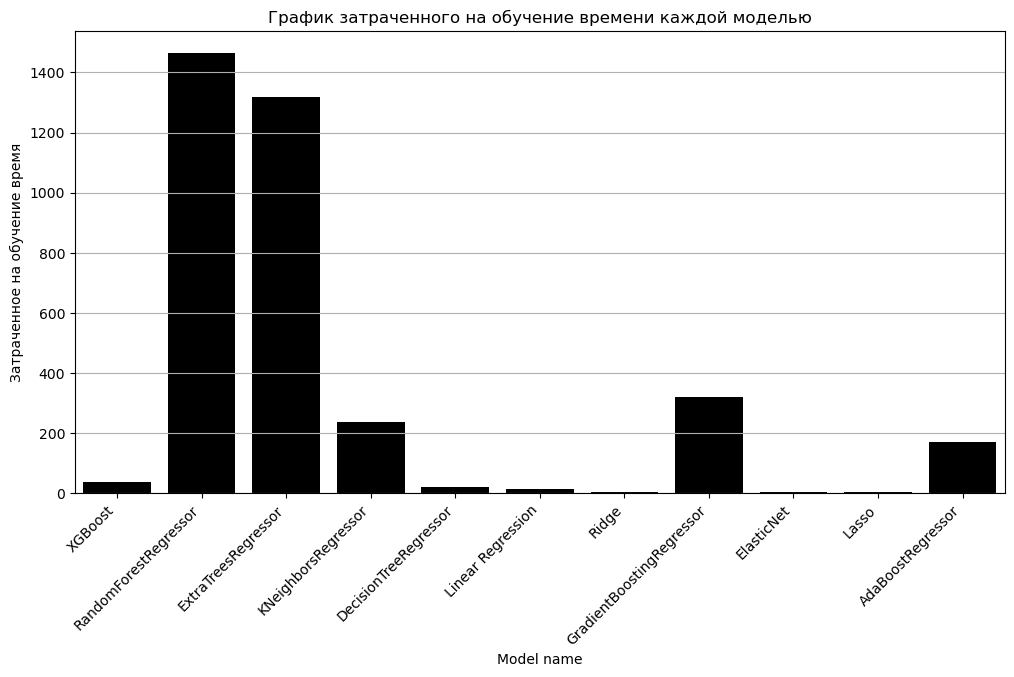

In [33]:
plt.figure(figsize=(12, 6))
sns.barplot(x=models_for_plot, y=time, color='black')
plt.title('График затраченного на обучение времени каждой моделью')
plt.xlabel('Model name')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Затраченное на обучение время')
plt.grid(axis='y')
plt.show()

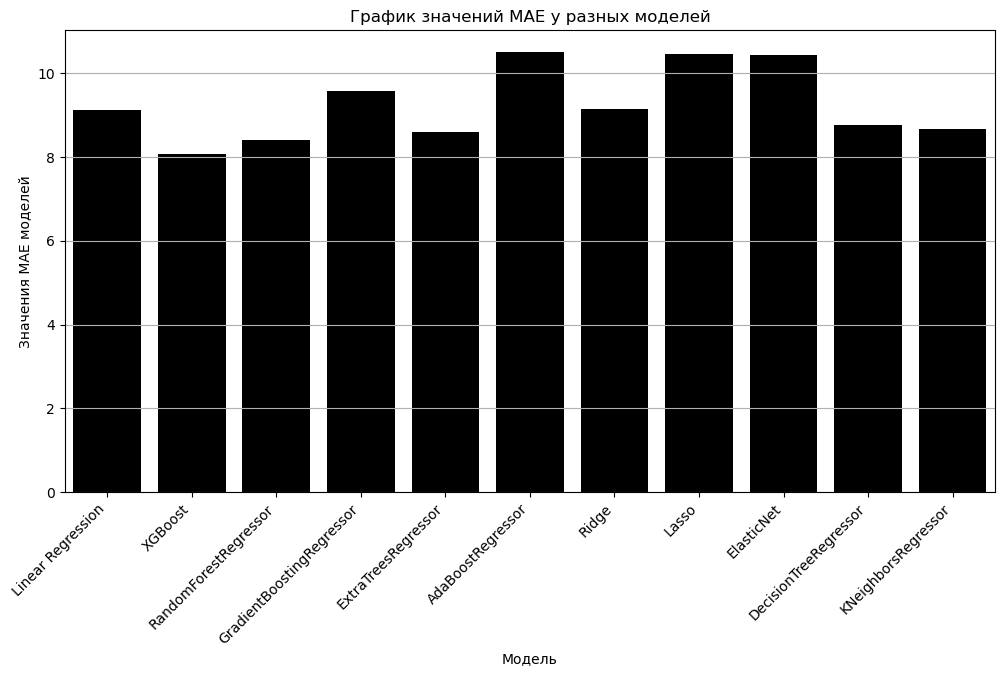

In [34]:
plt.figure(figsize=(12, 6))
sns.barplot(x=mae_scores.keys(), y=mae_scores.values(), color='black')
plt.title('График значений MAE у разных моделей')
plt.xlabel('Модель')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Значения MAE моделей')
plt.grid(axis='y')
plt.show()

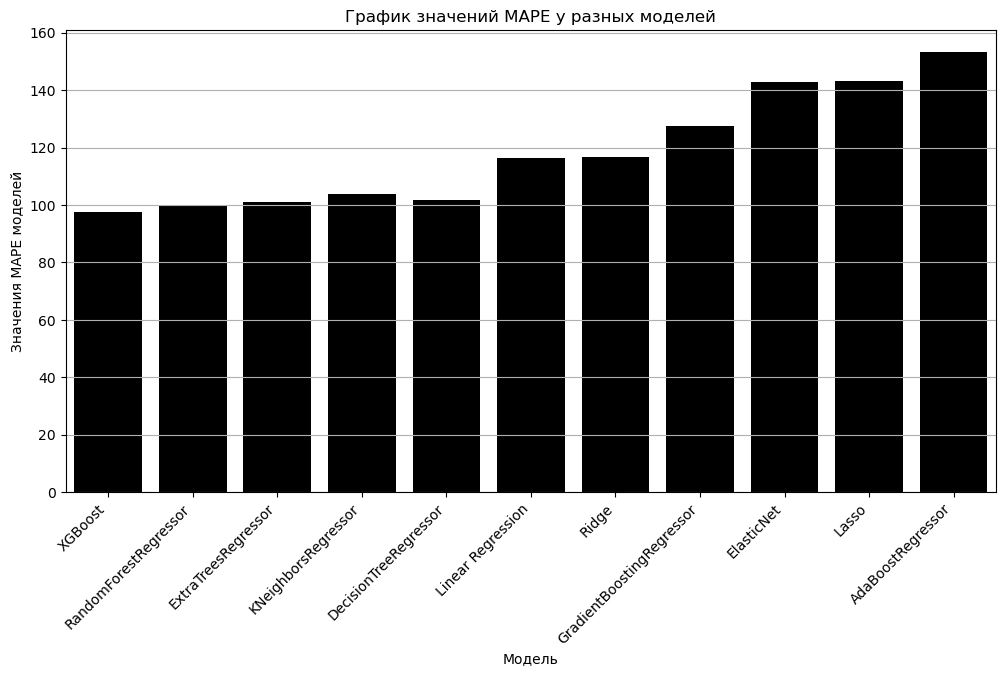

In [35]:
plt.figure(figsize=(12, 6))
sns.barplot(x=models_for_plot, y=mape, color='black')
plt.title('График значений MAPE у разных моделей')
plt.xlabel('Модель')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Значения MAPE моделей')
plt.grid(axis='y')
plt.show()

In [36]:
max_time = max(time_spent.values())
max_mae = max(mae_scores.values())
normalized_results = {}
for name, model in models.items():
    normalized_results[name] = {
        'efficiency': 0.2 * time_spent[name] / max_time + 0.8 * mae_scores[name] / max_mae
    }
models_to_efficiency_map = {}

for k in normalized_results:
    models_to_efficiency_map[k] = normalized_results[k]['efficiency']

sorted_models_to_efficiency_map = dict(sorted(models_to_efficiency_map.items(), key=lambda x:x[1]))

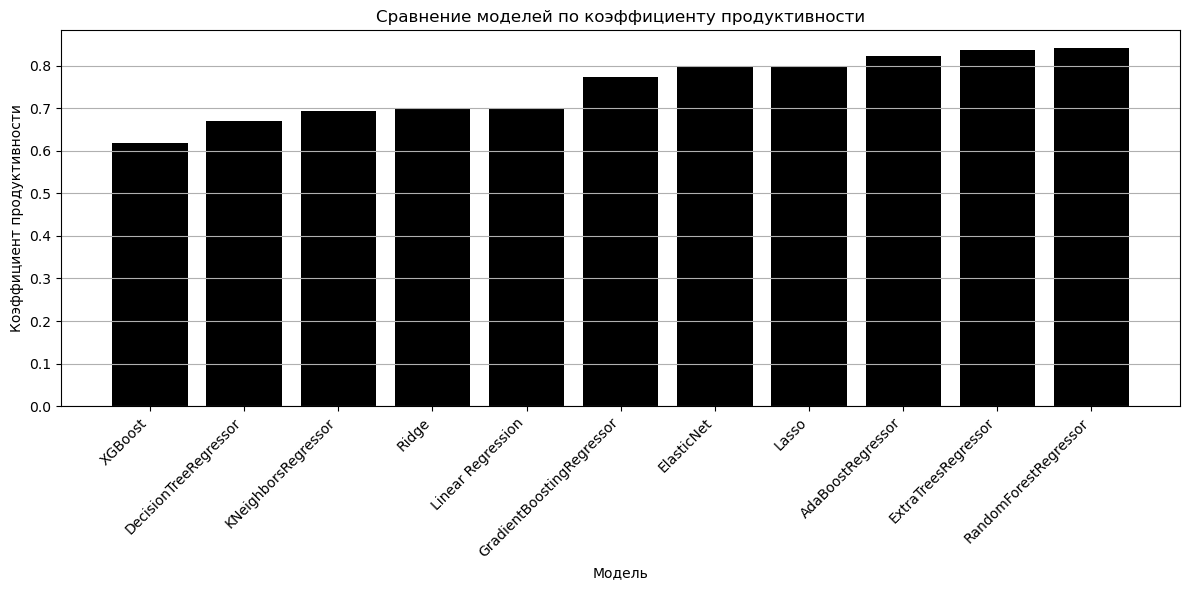

In [37]:
plt.figure(figsize=(12, 6))
plt.bar(list(sorted_models_to_efficiency_map.keys()), sorted_models_to_efficiency_map.values(), color='black')
plt.xlabel("Модель")
plt.ylabel("Коэффициент продуктивности")
plt.title("Сравнение моделей по коэффициенту продуктивности")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.grid(axis='y')
plt.show()

# С помощью RandomizedSearchCV подбираем лучшие гиперпараметры для модели XGBRegressor

### Подбор гиперпараметров

In [38]:
param_distributions = {
    'n_estimators': np.random.randint(50, 300, 7),
    'learning_rate': np.random.uniform(0.01, 0.9, 7),
    'max_depth': np.random.randint(5, 12, 7)
}

model = XGBRegressor(objective='reg:squarederror', random_state=42)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=49,
    scoring='neg_mean_absolute_error',
    n_jobs=-1, 
)
random_search.fit(X_train_split, y_train_split)

RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,...
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_iter=49, n_jobs=-1,
                   param_distributions={'learning_rate': array([0.18710335, 0.56135378, 0.41074625, 0.15887623, 0.10931612,
       0.82799349, 0.50794182]),
                                        'max_depth': array([ 7,  6,  8,  6,  6,  6, 11]),
                                        'n_estimators': array([277, 143, 259, 175, 290, 150, 212])},
                   scoring='neg_mean_absolute_error')

### Обучение модели

In [39]:
results = {}
for i, (params, mean_score) in enumerate(zip(random_search.cv_results_['params'],
                                             -random_search.cv_results_['mean_test_score'])):
    y_val_pred = random_search.predict(X_val_split)
    mae = mean_absolute_error(y_val_split, y_val_pred)
    results[tuple(sorted(params.items()))] = mae 

print(f"Лучшие параметры: {random_search.best_params_}, MAE: {-random_search.best_score_}")

best_model = random_search.best_estimator_

best_model.fit(X_train, y_train)

Лучшие параметры: {'n_estimators': 290, 'max_depth': 6, 'learning_rate': 0.561353781490268}, MAE: 8.04938325057147


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.561353781490268,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=290, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

### Построение графика

In [40]:
X_test = sample_submission_encoded
y_test_pred = best_model.predict(X_test)

sample_submission['visitors']=y_test_pred
avg_visitors_pred = sample_submission.groupby('visit_date')['visitors'].mean().reset_index()

avg_X = (avg_visitors_pred['visit_date'] - avg_visitors_pred['visit_date'].min()).dt.days.values.reshape(-1, 1)
avg_y = avg_visitors_pred['visitors']
polynom = PolynomialFeatures(degree=4)
polynom_X = polynom.fit_transform(avg_X)
model = LinearRegression()
model.fit(polynom_X, avg_y)
polynom_pred_y = model.predict(polynom_X)

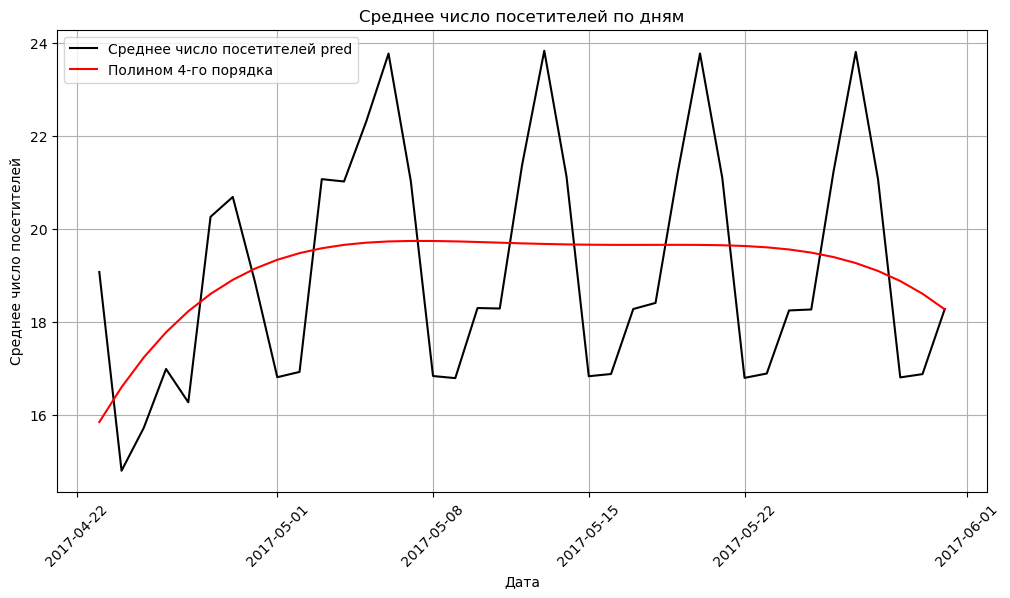

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(avg_visitors_pred['visit_date'], avg_visitors_pred['visitors'], color='black', label='Среднее число посетителей pred')
plt.plot(avg_visitors_pred['visit_date'], polynom_pred_y, color='red', label='Полином 4-го порядка')
plt.title('Среднее число посетителей по дням')
plt.xlabel('Дата')
plt.ylabel('Среднее число посетителей')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()